# **Notebook: Introdução à Computação no Mercado Financeiro**

**Trabalho 3: Alocação sistemática em classes de ativos usando Machine Learning**

SSC0964 - Prof. Denis Fernando Wolf

Instituto de Ciências Matemáticas e de Computação (ICMC-USP)

Amanda Araujo Silva

*Link Colab*: https://colab.research.google.com/drive/1E9dj5omYkigIb00XyxZCUzoNdzsqZlT_?usp=sharing

# Descrição do trabalho

A partir do material visto nas aulas, utilizar técnicas de aprendizado de
máquina para criar algoritmos de alocação ou trading sistemático.
- Devem ser apresentadas duas estratégias, baseadas em técnicas de
aprendizado de máquina diferentes (Redes Neurais MLP, Árvores de Decisão
ou outras técnicas não vistas na aula).
- Os algoritmos desenvolvidos devem utilzar conjuntos dados de entrada e
saída diferentes daqueles usados nas aulas.
No caso da alocação sistemática, outras classes de ativos devem ser
utilizados ou adicionadas às entradas e saídas dos algoritmos.
No caso do trading sistemático, outros indicadores devem ser utilizados ou
adicionadas às entradas dos algoritmos.
- Apresentar os resultados de ambos os conjuntos de dados de treinamento e
validação.
A avaliação levará em conta a forma a originalidade na escolha dos dados
de entrada e dos algoritmos, resultados obtidos e o número de alunos no
grupo.

# Instalação de pacotes e bibliotecas

In [ ]:
# Scikit Learn: Aprendizado de Máquina
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
# Bibliotecas e pacotes úteis
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

sns.set(style = 'whitegrid')

# Leitura dos dados

In [ ]:
# Leitura dos dados
dados = pd.read_excel('/content/Dados_Classes_Indices.xlsx', engine='openpyxl')
dados.set_index(keys = 'Data', inplace = True)

In [ ]:
dados

,USD,IBOV,IMAB,IPCA,SELIC-ACC,SELIC-META,SP500BR
Data,,,,,,,
Set-2003,2.9234,16010.00,732.134779,10.520830,987.926836,19.84,2911.618698
Out-2003,2.8562,17982.00,749.921194,10.551340,1004.149186,18.85,3001.037902
Nov-2003,2.9494,20183.00,780.713506,10.587210,1017.640246,17.32,3121.055080
Dez-2003,2.8892,22236.00,811.970067,10.642263,1031.614995,16.33,3212.559264
Jan-2004,2.9409,21851.00,859.640824,10.723145,1044.691245,16.29,3326.481399
...,...,...,...,...,...,...,...
Dez-2022,5.2177,109734.60,8536.599187,30.905169,7002.464380,13.65,20033.359150
Jan-2023,5.0993,113430.54,8536.526930,31.068966,7081.124150,13.65,20787.806380
Fev-2023,5.2078,104931.93,8645.939192,31.329946,7146.138920,13.65,20675.747170


Do arquivo de dados "Dados_Classes_Indices.xlxs" obtemos informações quanto à cotação de diferentes classes de ativos, aqui representadas por:
* Dólar americano (USD);
* Ibovespa (IBOV): pricipal índice da bolsa brasileira, representa ações brasileiras;
* IMA-B (IMAB): índice que indica os rendimentos de títulos públicos atrelados à inflação (Tesouro IPCA+), além de uma taxa de juros pré-fixada;
* Índice Nacional de Preços do Consumidor Amplo (IPCA): índice oficial de inflação no país;
* SELIC: taxa básica de juros da economia;
* SP500BR: principal índice da bolsa americana, valores em reais (R$).

Fonte: https://comoinvestir.anbima.com.br/noticia/conheca-o-ima-b/

# Visualização dos dados

Para melhor visualização dos dados, em termos do crescimento de cada classe de ativo, os valores foram normalizados para base 1.

In [ ]:
#Ajuste para base 1, exceção da taxa SELIC META
dados_selic_meta = dados['SELIC-META']
dados_norm = dados/dados.iloc[0]
dados_norm['SELIC-META'] = dados_selic_meta

<Axes: xlabel='Data'>

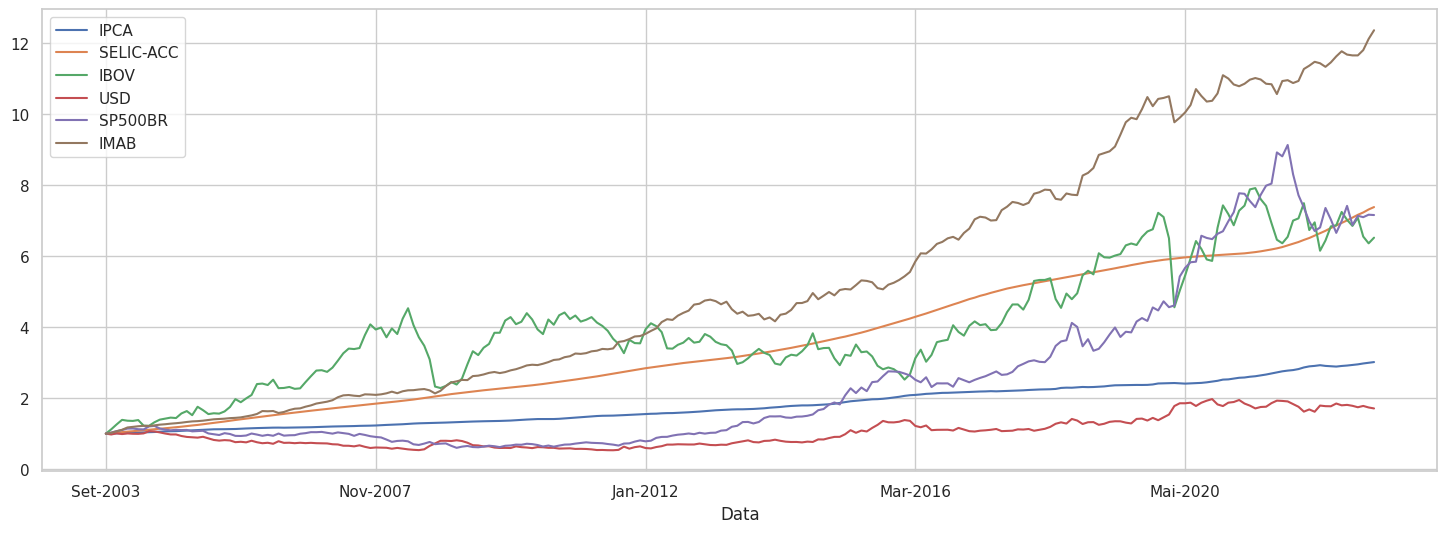

In [ ]:
dados_norm[['IPCA', 'SELIC-ACC', 'IBOV', 'USD', 'SP500BR', 'IMAB']].plot(figsize=(18,6), grid = True)

<Axes: xlabel='Data'>

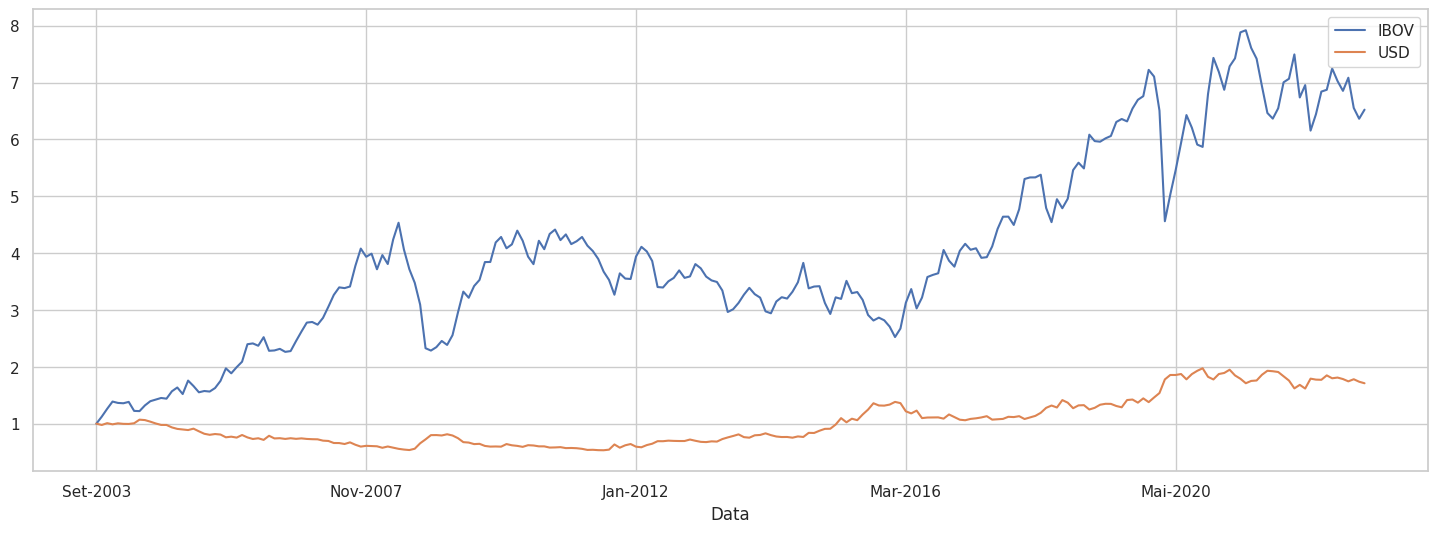

In [ ]:
dados_norm[['IBOV', 'USD']].plot(figsize=(18,6), grid = True)

Ao visualizar o desempenho das classes de ativos no período (Set-2003 - Abr-2023), nota-se uma correlação negativa entre Ibovespa (IBOV) e dólar americano (USD), ou seja, de modo geral, enquanto IBOV sobe, USD desce, e vice-versa. Vamos tentar explorá-la, juntamente com o uso de *machine learning*, de modo a desenvolver um modelo de alocação sistemática de ativos que se saia melhor do que o investimento estático em uma única classe.

# Algoritmos de Aprendizado de Máquina (Machine Learning)

Foram utilizados dois tipos de algoritmos de aprendizado de máquina:
* Árvore de Decisão
* Redes Neurais Artificiais: Multilayer Perceptron (MLP)

Neste trabalho, a ideia consiste em utilizar ferramentas de machine learning para auxiliar na tomada de decisões relativas a composição de um portifólio, pensando em classes de ativo. As classes escolhidas se tratam do IBOV (representando empresas brasileiras) e dólar americano (USD). Estas parecem uma escolha interessante, devido à correlação negativa entre elas.

**Estratégia de alocação sistemática**

Alocação de capital em duas classes de ativos: IBOV e USD.
Estratégica sistemática simples de alocação:
* Subida USD: sai do ibovespa e aloca capital em dólar americano;
* Descida USD: aloca capital no índice Ibovespa.

Ideia: sempre alocar recursos na classe de ativos de obteve maior crescimento/melhor resultado.

# Etapas preliminares

Dos dados disponíveis, *i.e.* séries temporais das classes de ativos, calculou-se as variações parciais mensais e *momentum* relativo aos últimos 1, 3 e 6 meses:

In [ ]:
# Cálculo das variações parciais mensais
dados_chg = dados.pct_change()
dados_chg.fillna(0, inplace = True)

In [ ]:
# Cálculo: Momentum de 1, 3 e 6 meses
dados_mom1 = dados.copy()
dados_mom1.iloc[0:3] = 0
mom_period = 1

for ind in range(mom_period, len(dados.index)):
  dados_mom1.iloc[ind] = dados.iloc[ind]/dados.iloc[ind - mom_period]

dados_mom3 = dados.copy()
dados_mom3.iloc[0:3] = 0
mom_period = 3

for ind in range(mom_period, len(dados.index)):
  dados_mom3.iloc[ind] = dados.iloc[ind]/dados.iloc[ind - mom_period]

dados_mom6 = dados.copy()
dados_mom6.iloc[0:3] = 0
mom_period = 6

for ind in range(mom_period, len(dados.index)):
  dados_mom6.iloc[ind] = dados.iloc[ind]/dados.iloc[ind - mom_period]

Criação do data frame para o algoritmo de aprendizado de máquina. Nele constam:
* Variações parciais mensais IBOV e USD
* Momentum 1, 3 e 6 meses (3 atributos)
* Resultados de alocação ideais (saída do algoritmo): IBOV-BUY e USD-BUY

In [ ]:
# Criando data frame com informações para o algoritmo de aprendizado de máquina
dados_apr = dados_chg[['IBOV', 'USD']].copy()

#Momentum IBOV e USD para entrada do algoritmo
dados_apr['MOM1-IBOV'] = dados_mom1['IBOV']
dados_apr['MOM3-IBOV'] = dados_mom3['IBOV']
dados_apr['MOM6-IBOV'] = dados_mom6['IBOV']

dados_apr['MOM1-USD'] = dados_mom1['USD']
dados_apr['MOM3-USD'] = dados_mom3['USD']
dados_apr['MOM6-USD'] = dados_mom6['USD']

#Saída do algoritmo: resultados de alocação ideal
#cálculo da alocação ideal (meta): quem foi melhor, IBOV ou USD; se USD > IBOV, alocação ideal naquele mês na USD;
dados_apr['IBOV-BUY'] = np.argmin(dados_apr[['IBOV', 'USD']].reset_index().drop(['Data'], axis=1).to_numpy(), axis=1)
dados_apr['USD-BUY'] = np.argmax(dados_apr[['IBOV', 'USD']].reset_index().drop(['Data'], axis=1).to_numpy(), axis=1)

In [ ]:
dados_apr

,IBOV,USD,MOM1-IBOV,MOM3-IBOV,MOM6-IBOV,MOM1-USD,MOM3-USD,MOM6-USD,IBOV-BUY,USD-BUY
Data,,,,,,,,,,
Set-2003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
Out-2003,0.123173,-0.022987,1.123173,0.000000,0.000000,0.977013,0.000000,0.000000,1,0
Nov-2003,0.122400,0.032631,1.122400,0.000000,0.000000,1.032631,0.000000,0.000000,1,0
Dez-2003,0.101719,-0.020411,1.101719,1.388882,22236.000000,0.979589,0.988301,2.889200,1,0
Jan-2004,-0.017314,0.017894,0.982686,1.215160,21851.000000,1.017894,1.029655,2.940900,0,1
...,...,...,...,...,...,...,...,...,...,...
Dez-2022,-0.024460,-0.014431,0.975540,0.997254,1.113583,0.985569,0.965061,0.996124,0,1
Jan-2023,0.033681,-0.022692,1.033681,0.977537,1.099509,0.977308,0.970002,0.982827,1,0
Fev-2023,-0.074923,0.021277,0.925077,0.932844,0.958082,1.021277,0.983699,1.005561,0,1


> As últimas duas colunas indicam em qual das duas classes gostaria de estar investido no período, *i.e.* indicam qual das duas classes obteve melhor desempenho em determinado instante de tempo. Por exemplo, em Out-2003, o IBOV marcou 0.123173, enquanto o dólar caiu; nesse instante específico seria melhor ter investimentos no Ibovespa (IBOV-BUY = 1, USD-BUY = 0). No entanto, em outro ponto no tempo, como por exemplo em Fev-2023, o dólar registra alta, enquanto o Ibovespa cai, sendo melhor ter trocado a composição da carteira (IBOV-BUY = 0, USD-BUY = 1).

> Note que: por meio da definição do resultado de alocação ideal como 0 ou 1 (100% do portifólio IBOV ou USD), transformamos o problema de alocação em um problema de decisão binária. Isso torna possível o uso de um algoritmo de classificação como a árvore de decisão.

Definição dos dados de entrada e saída a serem fornecidos ao algoritmo:

In [ ]:
# Dados de entrada e saída
din = dados_apr[['MOM1-IBOV', 'MOM3-IBOV', 'MOM6-IBOV', 'MOM1-USD', 'MOM3-USD', 'MOM6-USD']].reset_index().drop(['Data'], axis=1).to_numpy()
dout = dados_apr[['IBOV-BUY', 'USD-BUY']].reset_index().drop(['Data'], axis=1).to_numpy()

Divisão das 236 entradas dos dados em conjuntos de treinamento e conjunto de validação:

In [ ]:
#Número de samples para treinamento
n_train = 100

#Separando em dados de treinamento e validação
train_in = din[12:12+n_train]
train_out = dout[13:13+n_train]

val_in = din[12+n_train:dout.shape[0]-1]
val_out = dout[13+n_train:dout.shape[0]]

# Árvore de Decisão
Construção, Resultados & Discussão

### Árvore de decisão: nível único

Começando a exploração do uso de árvores de decisão para definição da melhor alocação de recursos entre duas classes de ativos, criou-se uma estrutura de árvore com apenas um único nó.

In [ ]:
#Treinamento Árvores de Decisão ou random forests
clf = DecisionTreeClassifier(random_state=1, max_depth=1) #cria estrutura da rede

clf.fit(train_in, train_out)

DecisionTreeClassifier(max_depth=1, random_state=1)

In [ ]:
# Avaliando os resultados
y_pred = clf.predict(train_in)
print('Accuracy train:', metrics.accuracy_score(train_out, y_pred))

y_pred = clf.predict(val_in)
print('Accuracy validation:', metrics.accuracy_score(val_out, y_pred))

y_pred = clf.predict(din)

Accuracy train: 0.6
Accuracy validation: 0.4634146341463415


> A árvore foi capaz de obter 60% de acurácia em seu conjunto de treinamento, no entanto, atingiu apenas 46,3% de acurácia no conjunto de validação.

Visualização da árvore de decisão e seus nós após passar pela etapa do conjunto de dados de treinamento:

In [ ]:
# Visualização árvore de decisão
#tree.plot_tree(clf)

import graphviz
dados_apr_names = list(dados_apr.keys())
dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=['MOM1-IBOV', 'MOM3-IBOV', 'MOM6-IBOV', 'MOM1-USD', 'MOM3-USD', 'MOM6-USD'],
                      class_names= ['IBOV-BUY', 'USD-BUY'],
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)

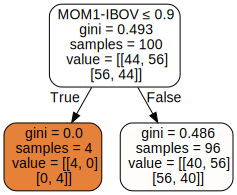

In [ ]:
graph

> Observa-se que ao construir uma árvore de um só nó, há um único *if* para realizar a tomada de decisão. Espera-se que o atributo escolhido seja o mais adequado, ou ao menos o mais relevante no problema de classificação, no caso: momentum do IBOV de 1 mês (MOM1-IBOV).

Analisando o desempenho do portifólio e das classes de ativos individualmente no período...

<Axes: xlabel='Data'>

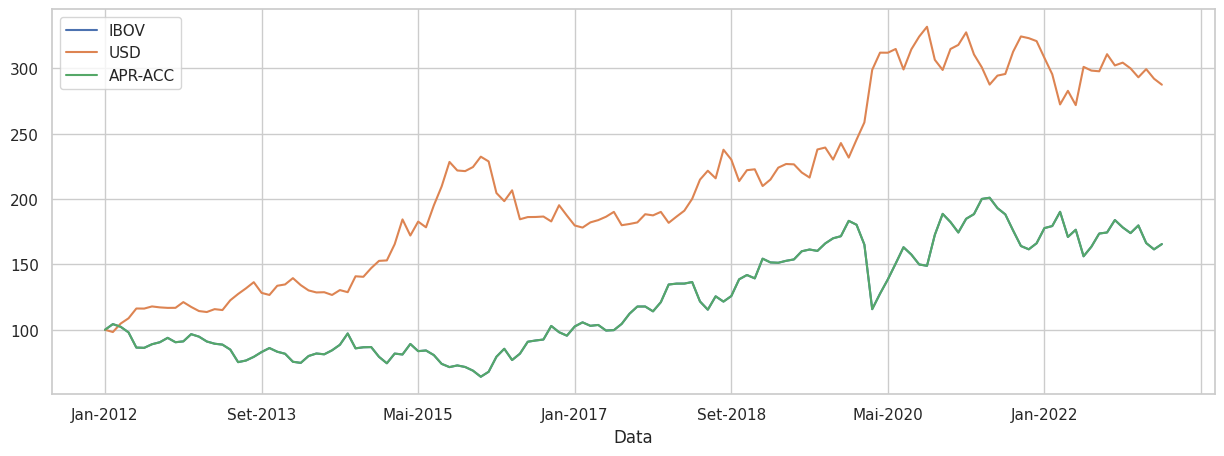

In [ ]:
# Copiando saídas do algoritmo de aprendizado para o data frame
dados_apr['IBOV-BUY-APR'] = np.argmin(y_pred, axis=1)
dados_apr['USD-BUY-APR'] = np.argmax(y_pred, axis=1)

#deslocando um mês para frente, pois tem que estimar o mês seguinte (futuro)
dados_apr['IBOV-BUY-APR'] = dados_apr['IBOV-BUY-APR'].shift(1)
dados_apr['USD-BUY-APR'] = dados_apr['USD-BUY-APR'].shift(1)

#Calculando o resultado acumulado do investimento utilizando aprendizado
dados_apr['APR-CHG'] = dados_apr['IBOV'] * dados_apr['IBOV-BUY-APR'] + dados_apr['USD'] * dados_apr['USD-BUY-APR']
dados['APR-ACC'] = (1 + dados_apr['APR-CHG']).cumprod()

# Gráfico de comparação IBOV x USD x Aprendizado
dados_arvore_1 = dados*100 / dados.iloc[n_train]
dados_arvore_1[['IBOV', 'USD', 'APR-ACC']].iloc[n_train:].plot(figsize = (15,5))

> Observa-se que o desempenho da carteira seguindo alocação sistemática orientada pela árvore de decisão em questão é pior do que as classes individualmente no período de validação analisado. Nota-se que de fato a alocação acompanha a dinâmica do IBOV, o que faz sentido com o fato do atributo escolhido para ocupar a raíz (e único nó) da árvore ter sido MOM1-IBOV.

In [ ]:
# Retorno e volatilidade IBOV x SELIC x Aprendizado
ref_data = n_train
periodo = int(len(dados.index[ref_data+1:])/12)
print("Periodo:", dados.index[ref_data+1], "-", dados.index[-1], '(', periodo,')')

ret_acc = (dados[['IBOV', 'USD', 'APR-ACC']].iloc[-1]/dados[['IBOV', 'USD', 'APR-ACC']].iloc[ref_data])
print("Retorno acumulado:\n", ret_acc)
ret_aa = ((dados[['IBOV', 'USD', 'APR-ACC']].iloc[-1]/dados[['IBOV', 'USD', 'APR-ACC']].iloc[ref_data])**(1/periodo))-1
print("Retorno anualizado:\n", ret_aa)
vol_aa = dados_apr[['IBOV', 'USD', 'APR-CHG']].iloc[ref_data+1:].std()*np.sqrt(12)
print("Vol anualizada:\n", vol_aa)

Periodo: Fev-2012 - Abr-2023 ( 11 )
Retorno acumulado:
 IBOV       1.655753
USD        2.875453
APR-ACC    1.271330
dtype: float64
Retorno anualizado:
 IBOV       0.046908
USD        0.100780
APR-ACC    0.022064
dtype: float64
Vol anualizada:
 IBOV       0.221852
USD        0.156292
APR-CHG    0.221640
dtype: float64


> Os resultados quantitativos confirmam o péssimo desempenho da nossa carteira, com menor retono do que IBOV e USD e volatilidade similar a do Ibovespa.

> O modelo de árvore de decisão de apenas 1 nó com os dados de entrada providos, não foi suficiente para entregar um portifólio de alocação sistemática que superasse as classes de ativos individualmente. No conjunto de treinamento ela apresentou acurácia de 60%, mas parece não ter sido capaz de generalizá-los para o conjunto de validação, o que se refletiu no seu desempenho.

### Árvore de decisão: múltiplos nós

Na busca por melhorar o resultado obtido, alterou-se o parâmetro de profundidade da árvore de decisão (*max_depth*).

In [ ]:
max_depth = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50]
acc_train = []
acc_val = []

for max in max_depth:
  #Treinamento Árvores de Decisão ou random forests
  clf = DecisionTreeClassifier(random_state=1, max_depth=max) #cria estrutura da rede

  clf.fit(train_in, train_out)

  # Avaliando os resultados
  y_pred = clf.predict(train_in)
  #print('Accuracy train:', metrics.accuracy_score(train_out, y_pred))
  acc_train.append(metrics.accuracy_score(train_out, y_pred))

  y_pred = clf.predict(val_in)
  #print('Accuracy validation:', metrics.accuracy_score(val_out, y_pred))
  acc_val.append(metrics.accuracy_score(val_out, y_pred))

  y_pred = clf.predict(din)

Curva de aprendizado do modelo de árvore de decisão, alterando o parâmetros de profundidade máxima:

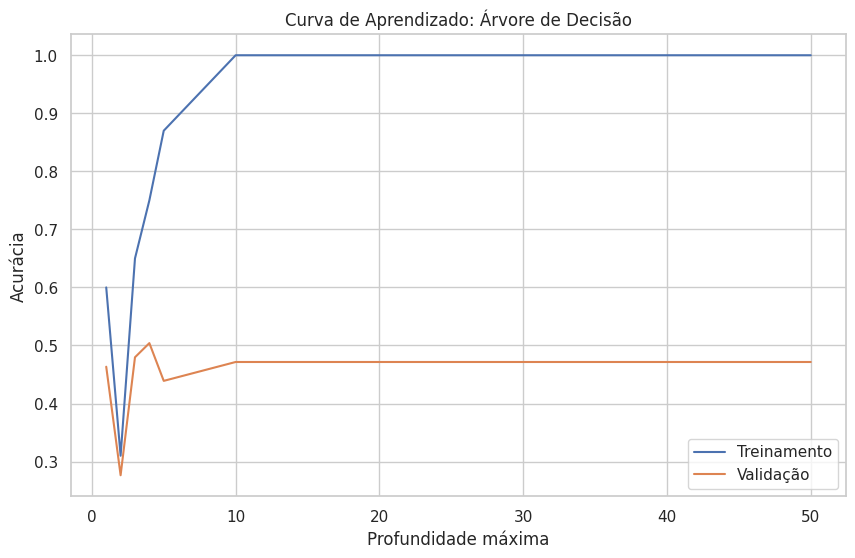

In [ ]:
# Curva de aprendizado: acurácia vs. profundidade
plt.figure(figsize = (10, 6))
plt.plot(max_depth, acc_train)
plt.plot(max_depth, acc_val)
plt.legend(['Treinamento', 'Validação'])
plt.title('Curva de Aprendizado: Árvore de Decisão')
plt.xlabel('Profundidade máxima')
plt.ylabel("Acurácia")
plt.show()

> Observa-se que a alteração no parâmetro da profundidade da árvore provoca mudança na acurácia obtida pelo modelo no conjunto de treinamento e de validação, de maneira não-linear. Há uma inicial piora, seguida de melhora e encaminhamento para um valor estacionário. Nota-se que rapidamente ao se aumentar a profundidade máxima, o modelo é capaz de decorar os dados de treinamento e performar de maneira excelente nessa primeira etapa, no entanto, estaca em uma acurácia de 47,15% para um conjunto de validação. Isso indica uma limitação do modelo, que a partir de um certo ponto perdeu a capacidade de generalizar e passa a realizar *overfitting* dos dados, o que garante 100% nos treinos, contudo, ao se ver diante de novos dados, fracassa.

In [ ]:
print('Accuracy training:', acc_train)
print('Accuracy validation:', acc_val)

Accuracy training: [0.6, 0.31, 0.65, 0.75, 0.87, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy validation: [0.4634146341463415, 0.2764227642276423, 0.4796747967479675, 0.5040650406504065, 0.43902439024390244, 0.4715447154471545, 0.4715447154471545, 0.4715447154471545, 0.4715447154471545, 0.4715447154471545, 0.4715447154471545]


"Zoom" na curva de aprendizado antes do modelo atingir um valor estacionário...

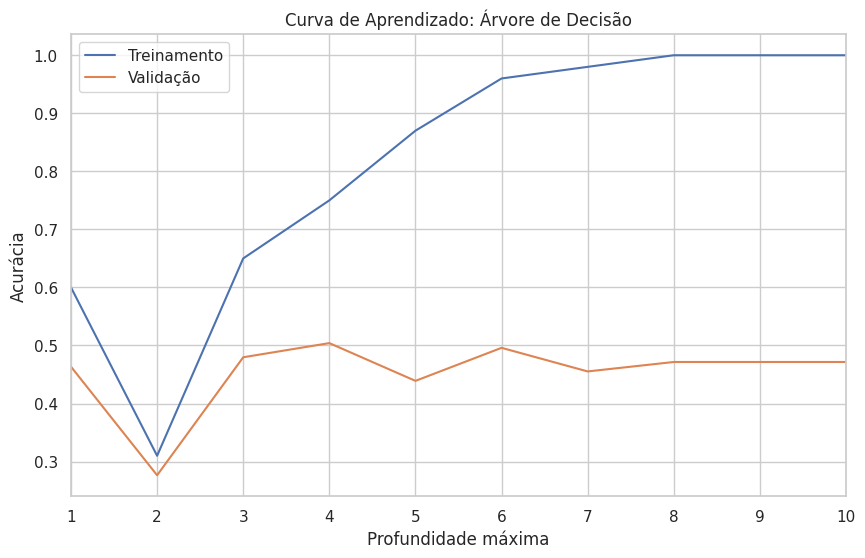

In [ ]:
# Curva de aprendizado: acurácia vs. profundidade (1 - 10)
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
acc_train = []
acc_val = []

for max in max_depth:
  #Treinamento Árvores de Decisão ou random forests
  clf = DecisionTreeClassifier(random_state=1, max_depth=max)

  clf.fit(train_in, train_out)

  # Avaliando os resultados
  y_pred = clf.predict(train_in)
  acc_train.append(metrics.accuracy_score(train_out, y_pred))

  y_pred = clf.predict(val_in)
  acc_val.append(metrics.accuracy_score(val_out, y_pred))

plt.figure(figsize = (10, 6))
plt.plot(max_depth, acc_train)
plt.plot(max_depth, acc_val)
plt.legend(['Treinamento', 'Validação'])
plt.title('Curva de Aprendizado: Árvore de Decisão')
plt.xlabel('Profundidade máxima')
plt.ylabel("Acurácia")
plt.xlim([1, 10])
plt.show()

> Olhando para a região do parâmetro antes de atingir o estado estacionário (*max_depth* < 10), é interessante notar que ambos os desempenhos para o conjunto de treinamento e validação se alteram de maneira não-linear. Ou seja, o mero aumento do número máximo de nós para tomada de decisão não é capaz de necessariamente melhorar o resultado final, isso fica claro para profudidade = 2, valor para o qual o modelo se saiu pior. É notável o fato de que mesmo após esse mínimo, a subida da acurácia, embora monótona para o conjunto de treinamento, é marcada por oscilação para o conjunto de validação, e o maior valor deste não é encontrado para o máximo daquele, o que leva a crer que haveria um valor ótimo de acurácia a ser atingindo na etapa de treinamento.
Dentre os modelos de árvore explorados, a profundidade máxima igual a 4 levou a uma acurácia de 75% no treinamento e 50,4065% na etapa de validação, aquém do que se deseja (em tese, praticamente tão bom quanto se jogar uma moeda).

As discussões até então se basearam nos valores de acurácia obtidos tendo em mente *machine learning*, no entanto, vamos agora nos ater aos dados reais de como as classes de ativos e nossos portifólios de alocação sistemática teriam se saído no período.

In [ ]:
# Função de apoio:
def arvore(max, train_in, train_out, val_in, val_out):
  #Treinamento Árvores de Decisão ou random forests
  clf = DecisionTreeClassifier(random_state=1, max_depth=max) #cria estrutura da rede

  clf.fit(train_in, train_out)

  # Avaliando os resultados
  y_pred = clf.predict(train_in)
  acc_train.append(metrics.accuracy_score(train_out, y_pred))

  y_pred = clf.predict(val_in)
  acc_val.append(metrics.accuracy_score(val_out, y_pred))

  y_pred = clf.predict(din)

  return y_pred

In [ ]:
max_depth = [1, 2, 3, 4, 5, 10]

for i in max_depth:
  y_pred = arvore(i, train_in, train_out, val_in, val_out)

  # Copiando saídas do algoritmo de aprendizado para o data frame
  dados_apr['IBOV-BUY-APR' + str(i)] = np.argmin(y_pred, axis=1)
  dados_apr['USD-BUY-APR' + str(i)] = np.argmax(y_pred, axis=1)

  #deslocando um mês para frente, pois tem que estimar o mês seguinte (futuro)
  dados_apr['IBOV-BUY-APR' + str(i)] = dados_apr['IBOV-BUY-APR' + str(i)].shift(1)
  dados_apr['USD-BUY-APR' + str(i)] = dados_apr['USD-BUY-APR' + str(i)].shift(1)

  #Calculando o resultado acumulado do investimento utilizando aprendizado
  dados_apr['APR-CHG' + str(i)] = dados_apr['IBOV'] * dados_apr['IBOV-BUY-APR' + str(i)] + dados_apr['USD'] * dados_apr['USD-BUY-APR' + str(i)]
  dados['APR-ACC' + str(i)] = (1 + dados_apr['APR-CHG' + str(i)]).cumprod()

<Axes: xlabel='Data'>

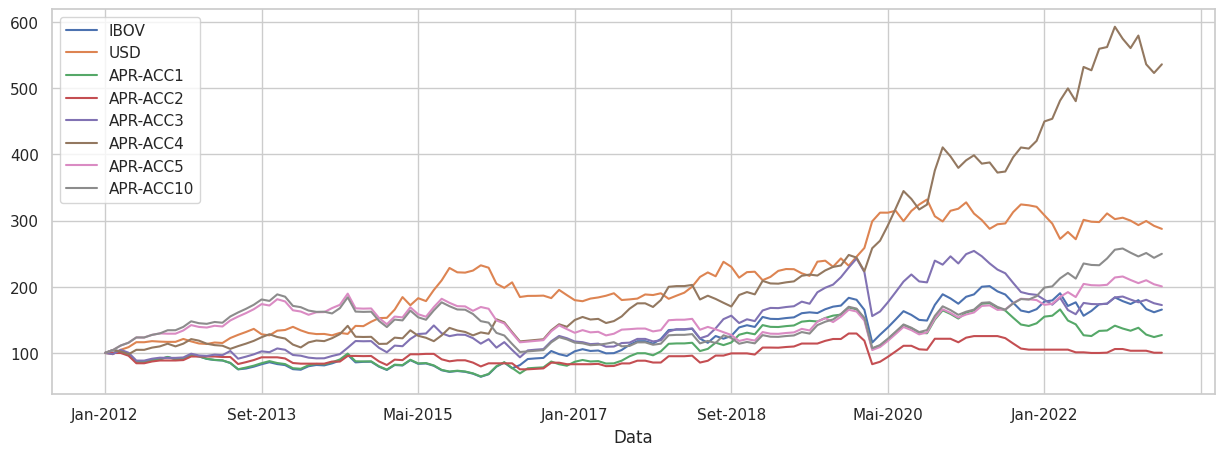

In [ ]:
# Gráfico de comparação IBOV x USD x Aprendizados
dados = dados*100 / dados.iloc[n_train]
dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
       'APR-ACC10']].iloc[n_train:].plot(figsize = (15,5))

> Nota-se que dentre as árvore de decisão, a alocação sistemática provida pela árvore de profundidade máxima 4 (APR-ACC4) foi a que se saiu melhor no período de validação, como esperado. De maneira supreendente, ela foi capaz de obter resultados muito acima de ambas as classes de ativos individualmente.

In [ ]:
# Retorno e volatilidade IBOV x USD x Aprendizados
ref_data = n_train
periodo = int(len(dados.index[ref_data+1:])/12)
print("Periodo:", dados.index[ref_data+1], "-", dados.index[-1], '(', periodo,')')

ret_acc = (dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
       'APR-ACC10']].iloc[-1]/dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
       'APR-ACC10']].iloc[ref_data])
print("Retorno acumulado:\n", ret_acc)

ret_aa = ((dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
       'APR-ACC10']].iloc[-1]/dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
       'APR-ACC10']].iloc[ref_data])**(1/periodo))-1
print("Retorno anualizado:\n", ret_aa)

vol_aa = dados_apr[['IBOV', 'USD', 'APR-CHG1', 'APR-CHG2', 'APR-CHG3', 'APR-CHG4', 'APR-CHG5',
       'APR-CHG10']].iloc[ref_data+1:].std()*np.sqrt(12)
print("Vol anualizada:\n", vol_aa)

Periodo: Fev-2012 - Abr-2023 ( 11 )
Retorno acumulado:
 IBOV         1.655753
USD          2.875453
APR-ACC1     1.271330
APR-ACC2     1.003555
APR-ACC3     1.723906
APR-ACC4     5.362140
APR-ACC5     2.006103
APR-ACC10    2.498843
dtype: float64
Retorno anualizado:
 IBOV         0.046908
USD          0.100780
APR-ACC1     0.022064
APR-ACC2     0.000323
APR-ACC3     0.050754
APR-ACC4     0.164940
APR-ACC5     0.065336
APR-ACC10    0.086821
dtype: float64
Vol anualizada:
 IBOV         0.221852
USD          0.156292
APR-CHG1     0.221640
APR-CHG2     0.179829
APR-CHG3     0.214933
APR-CHG4     0.187203
APR-CHG5     0.198661
APR-CHG10    0.202261
dtype: float64


> Os resultados quantitativos mostram que a árvore de decisão de *max_depth* = 4 apresenta retornos muito maiores do que IBOV e USD, com uma volatilidade entre as duas classes de ativos, um pouco mais volátil que o dólar americano e menos arriscada do que o Ibovespa.

> Muito curioso esse resultado...

Investigando a árvore de decisão de profundidade máxima igual a 4 gerada após o passar pela etapa de treinamento com um conjunto de teste de tamanho 100 ...

In [ ]:
#Treinamento Árvores de Decisão
clf = DecisionTreeClassifier(random_state=1, max_depth=4)
clf.fit(train_in, train_out)

# Visualização árvore de decisão
#tree.plot_tree(clf)
import graphviz
dados_apr_names = list(dados_apr.keys())
dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=['MOM1-IBOV', 'MOM3-IBOV', 'MOM6-IBOV', 'MOM1-USD', 'MOM3-USD', 'MOM6-USD'],
                      class_names= ['IBOV-BUY', 'USD-BUY'],
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)

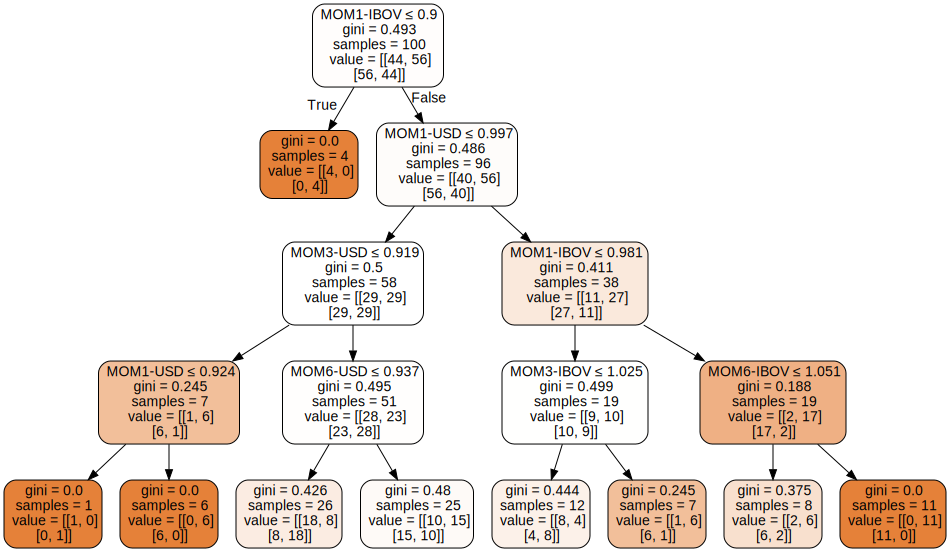

In [ ]:
graph

> Observa-se que a raíz da árvore se mantém aquela observada para a árvore de nó único: MOM1-IBOV, e que logo em seguida aparece em cena o MOM1-USD. Aparentemente esses dois atributos seriam muito relevantes, e é interessante notar que todos os momentos calculados para 1, 3 e 6 meses para IBOV e USD aparecem em algum nó e se fazem relevantes na tomada de decisão.

# Redes Neurais Artificiais: MLP
Construção, Resultados & Discussão

Reutilizando o mesmo arquivo de dados, cálculos do momentum (1, 3 e 6 meses), preparo do data frame dos dados de aprendizado, preparo das entradas e saídas para o conjunto de treinamento e de validação...

In [ ]:
# Leitura dos dados
dados = pd.read_excel('/content/Dados_Classes_Indices.xlsx', engine='openpyxl')
dados.set_index(keys = 'Data', inplace = True)

In [ ]:
# Cálculo das variações parciais mensais
dados_chg = dados.pct_change()
dados_chg.fillna(0, inplace = True)

In [ ]:
# Cálculo: Momentum de 1, 3 e 6 meses
dados_mom1 = dados.copy()
dados_mom1.iloc[0:3] = 0
mom_period = 1

for ind in range(mom_period, len(dados.index)):
  dados_mom1.iloc[ind] = dados.iloc[ind]/dados.iloc[ind - mom_period]

dados_mom3 = dados.copy()
dados_mom3.iloc[0:3] = 0
mom_period = 3

for ind in range(mom_period, len(dados.index)):
  dados_mom3.iloc[ind] = dados.iloc[ind]/dados.iloc[ind - mom_period]

dados_mom6 = dados.copy()
dados_mom6.iloc[0:3] = 0
mom_period = 6

for ind in range(mom_period, len(dados.index)):
  dados_mom6.iloc[ind] = dados.iloc[ind]/dados.iloc[ind - mom_period]

In [ ]:
def df_dados_apr(dados_chg, dados_mom1, dados_mom3, dados_mom6):
  # Criando data frame com informações para o algoritmo de aprendizado de máquina
  dados_apr = dados_chg[['IBOV', 'USD']].copy()

  #Momentum IBOV e USD para entrada do algoritmo
  dados_apr['MOM1-IBOV'] = dados_mom1['IBOV']
  dados_apr['MOM3-IBOV'] = dados_mom3['IBOV']
  dados_apr['MOM6-IBOV'] = dados_mom6['IBOV']

  dados_apr['MOM1-USD'] = dados_mom1['USD']
  dados_apr['MOM3-USD'] = dados_mom3['USD']
  dados_apr['MOM6-USD'] = dados_mom6['USD']

  #Saída do algoritmo: resultados de alocação ideal
  #cálculo da alocação ideal (meta): quem foi melhor, IBOV ou USD; se USD > IBOV, alocação ideal naquele mês na USD;
  dados_apr['IBOV-BUY'] = np.argmin(dados_apr[['IBOV', 'USD']].reset_index().drop(['Data'], axis=1).to_numpy(), axis=1)
  dados_apr['USD-BUY'] = np.argmax(dados_apr[['IBOV', 'USD']].reset_index().drop(['Data'], axis=1).to_numpy(), axis=1)

  return dados_apr

dados_apr = df_dados_apr(dados_chg, dados_mom1, dados_mom3, dados_mom6)

In [ ]:
# Dados de entrada e saída
din = dados_apr[['MOM1-IBOV', 'MOM3-IBOV', 'MOM6-IBOV', 'MOM1-USD', 'MOM3-USD', 'MOM6-USD']].reset_index().drop(['Data'], axis=1).to_numpy()
dout = dados_apr[['IBOV-BUY', 'USD-BUY']].reset_index().drop(['Data'], axis=1).to_numpy()

In [ ]:
#Número de samples para treinamento
n_train = 100

#Separando em dados de treinamento e validação
train_in = din[12:12+n_train]
train_out = dout[13:13+n_train]

val_in = din[12+n_train:dout.shape[0]-1]
val_out = dout[13+n_train:dout.shape[0]]

In [ ]:
# Treinamento com Redes Neurais MLP (MultiLayer Perceptron)

clf = MLPClassifier(random_state=1, hidden_layer_sizes=(2, ), max_iter=1000,
                    solver='adam', activation='relu') #cria rede neural
#clf = MLPClassifier(random_state=1, hidden_layer_sizes=(2, ), max_iter=10000,
                    #solver='lbfgs', activation='tanh')
clf.fit(train_in, train_out)

MLPClassifier(hidden_layer_sizes=(2,), max_iter=1000, random_state=1)

## Rede Neural MLP: adam & relu
Solver: 'adam' e activation: 'relu'

In [ ]:
def mlp(solver, f_act, h1, max_iter, train_in, train_out, val_in, val_out):
  # Treinamento com Redes Neurais MLP (MultiLayer Perceptron)
  clf = MLPClassifier(random_state=1, hidden_layer_sizes=(h1, ), max_iter=1000,
                      solver= solver, activation= f_act) #cria rede neural

  clf.fit(train_in, train_out)

  # Avaliando os resultados
  y_pred = clf.predict(train_in)
  #print('Accuracy train:', metrics.accuracy_score(train_out, y_pred))
  acc_train.append(metrics.accuracy_score(train_out, y_pred))

  y_pred = clf.predict(val_in)
  #print('Accuracy validation:', metrics.accuracy_score(val_out, y_pred))
  acc_val.append(metrics.accuracy_score(val_out, y_pred))

  y_pred = clf.predict(din)
  return y_pred

Foram criadas e treinadas redes neurais MLP com *solver* 'adam' e função de ativação 'relu' explorando diferentes quantidades de neurônios intermediários:

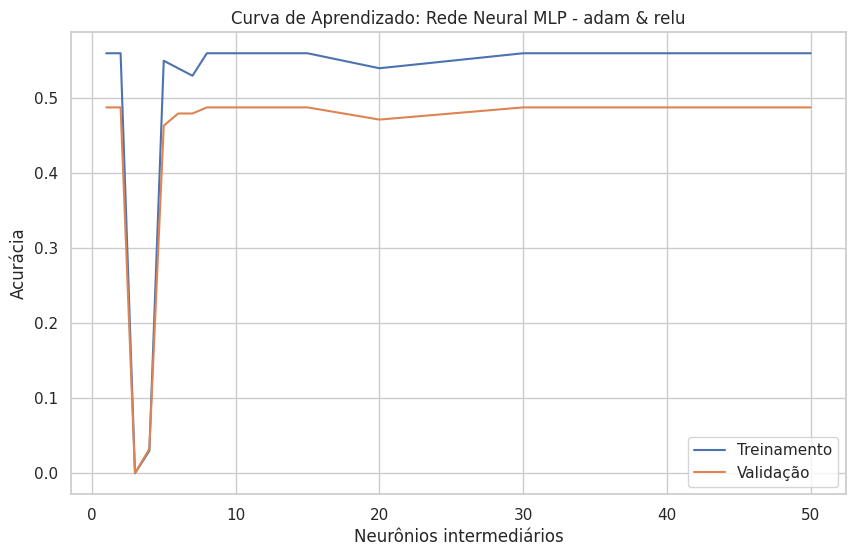

In [ ]:
# Treinamento com Redes Neurais MLP (MultiLayer Perceptron)
#solver: 'adam', função de ativação: 'relu'
#Diferentes quantidades de neurônios intermediários

solver = 'adam'
f_act = 'relu'
hidden1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]
max_iter = 1000
acc_train = []
acc_val = []

for h1 in hidden1:
  y_pred = mlp(solver, f_act, h1, max_iter, train_in, train_out, val_in, val_out)

# Curva de aprendizado: acurácia vs. neurônios intermediários
plt.figure(figsize = (10, 6))
plt.plot(hidden1, acc_train)
plt.plot(hidden1, acc_val)
plt.legend(['Treinamento', 'Validação'])
plt.title('Curva de Aprendizado: Rede Neural MLP - adam & relu')
plt.xlabel('Neurônios intermediários')
plt.ylabel("Acurácia")
plt.show()

> Observa-se que o desempenho da rede tende a um valor estacionário conforme o nº de neurônios intermediários aumenta, apresentando acurácia em torno de 56% para o conjunto de treinamento e 48,78% para o conjunto de validação. Mais uma vez, temos que a curva de aprendizado é não-linear, e que no geral a rede não foi capaz de generalizar todo o seu aprendizado supostamente obtido na etapa de treinamento para a etapa de validação, evidenciado pelo fato da acurácia desta estar sempre abaixo daquela.  

In [ ]:
print('Accuracy training:', acc_train)
print('Accuracy validation:', acc_val)

Accuracy training: [0.56, 0.56, 0.0, 0.03, 0.55, 0.54, 0.53, 0.56, 0.56, 0.56, 0.56, 0.54, 0.56, 0.56, 0.56]
Accuracy validation: [0.4878048780487805, 0.4878048780487805, 0.0, 0.032520325203252036, 0.4634146341463415, 0.4796747967479675, 0.4796747967479675, 0.4878048780487805, 0.4878048780487805, 0.4878048780487805, 0.4878048780487805, 0.4715447154471545, 0.4878048780487805, 0.4878048780487805, 0.4878048780487805]


Conferindo como as redes e a alocação sistemática sugerida por elas se comporta na prática, vamos aos dados financeiros referentes ao período de validação...

In [ ]:
# Retorno & Volatilidade
acc_train = []
acc_val = []

for i in hidden1:
  y_pred = mlp(solver, f_act, i, max_iter, train_in, train_out, val_in, val_out)

  # Copiando saídas do algoritmo de aprendizado para o data frame
  dados_apr['IBOV-BUY-APR' + str(i)] = np.argmin(y_pred, axis=1)
  dados_apr['USD-BUY-APR' + str(i)] = np.argmax(y_pred, axis=1)

  #deslocando um mês para frente, pois tem que estimar o mês seguinte (futuro)
  dados_apr['IBOV-BUY-APR' + str(i)] = dados_apr['IBOV-BUY-APR' + str(i)].shift(1)
  dados_apr['USD-BUY-APR' + str(i)] = dados_apr['USD-BUY-APR' + str(i)].shift(1)

  #Calculando o resultado acumulado do investimento utilizando aprendizado
  dados_apr['APR-CHG' + str(i)] = dados_apr['IBOV'] * dados_apr['IBOV-BUY-APR' + str(i)] + dados_apr['USD'] * dados_apr['USD-BUY-APR' + str(i)]
  dados['APR-ACC' + str(i)] = (1 + dados_apr['APR-CHG' + str(i)]).cumprod()

<Axes: xlabel='Data'>

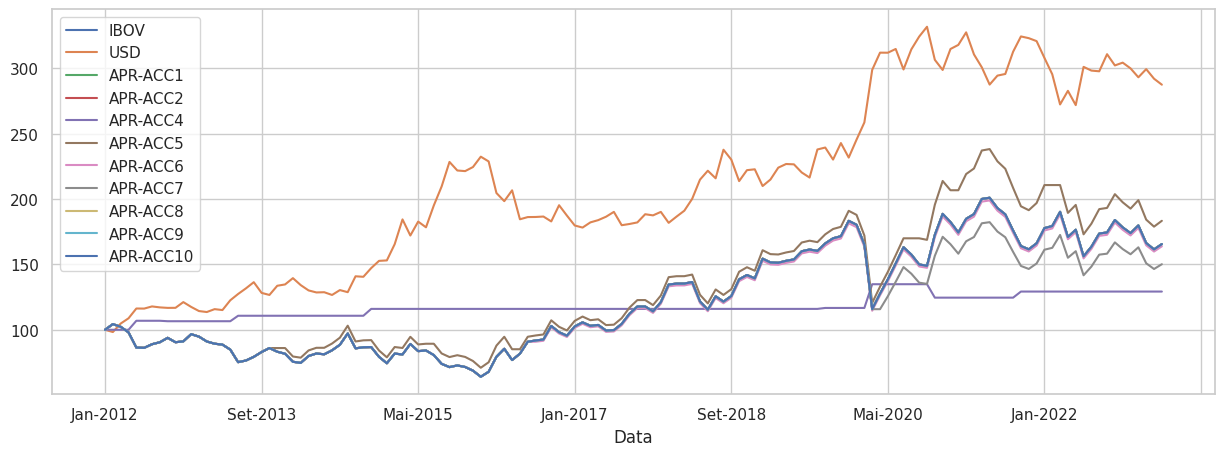

In [ ]:
# Gráfico de comparação IBOV x USD x Aprendizados
dados = dados*100 / dados.iloc[n_train]
dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC4', 'APR-ACC5',
       'APR-ACC6', 'APR-ACC7', 'APR-ACC8', 'APR-ACC9', 'APR-ACC10']].iloc[n_train:].plot(figsize = (15,5))

<Axes: xlabel='Data'>

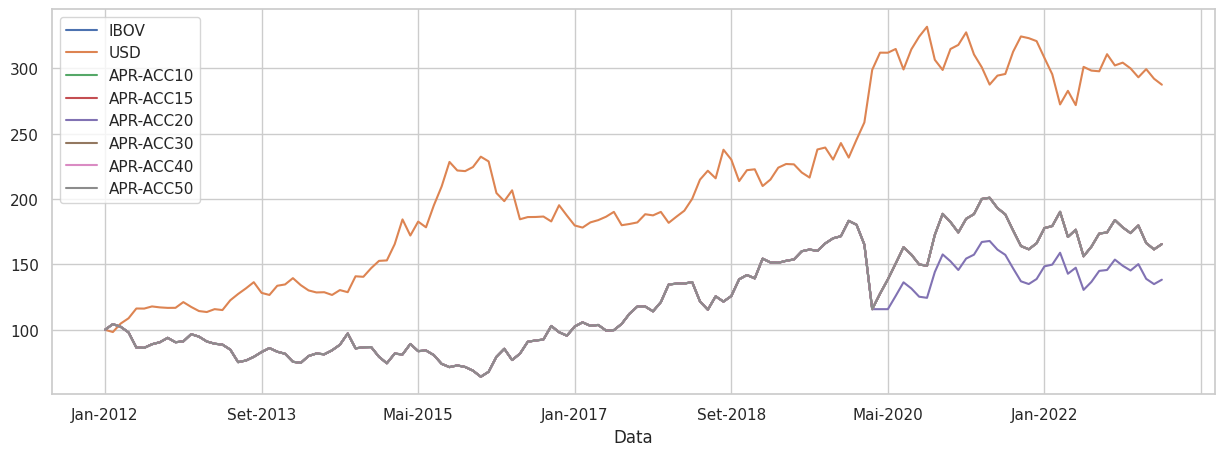

In [ ]:
dados[['IBOV', 'USD', 'APR-ACC10','APR-ACC15',
       'APR-ACC20', 'APR-ACC30', 'APR-ACC40', 'APR-ACC50']].iloc[n_train:].plot(figsize = (15,5))

> Observa-se que todas as redes MLP geradas, sem exceção, ficaram com retorno acumulado abaixo da classe de ativo dólar americano (USD), ou seja, se mostram em termos de máximização do retorno, uma estratégia ruim de investimento.

> Nota-se que, principalmente para os MLP com mais neurônios na camada intermediária, o "aprendizado" se resumiu basicamente a imitar o IBOV. Outra observação interessante, é que todas elas tendem a caminhar juntas no começo do período, com uma maior divergência observada logo antes de Mai-2020, momento onde estoura a pandemia de COVID-19, um fato inesperado; se havia algum padrão antes, de certo a situação do coronavírus bagunçou as predições para o período futuro.  

Olhando para os dados quantitativos do período...

In [ ]:
# Retorno e volatilidade IBOV x USD x Aprendizados

def ret_vol(n_train, dados, dados_apr):
  ref_data = n_train
  periodo = int(len(dados.index[ref_data+1:])/12)
  #print("Periodo:", dados.index[ref_data+1], "-", dados.index[-1], '(', periodo,')')

  ret_acc = (dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
        'APR-ACC6', 'APR-ACC7', 'APR-ACC8', 'APR-ACC9', 'APR-ACC10', 'APR-ACC15',
        'APR-ACC20', 'APR-ACC30', 'APR-ACC40', 'APR-ACC50']].iloc[-1]/dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
        'APR-ACC6', 'APR-ACC7', 'APR-ACC8', 'APR-ACC9', 'APR-ACC10', 'APR-ACC15',
        'APR-ACC20', 'APR-ACC30', 'APR-ACC40', 'APR-ACC50']].iloc[ref_data])
  #print("Retorno acumulado:\n", ret_acc)

  ret_aa = ((dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
        'APR-ACC6', 'APR-ACC7', 'APR-ACC8', 'APR-ACC9', 'APR-ACC10', 'APR-ACC15',
        'APR-ACC20', 'APR-ACC30', 'APR-ACC40', 'APR-ACC50']].iloc[-1]/dados[['IBOV', 'USD', 'APR-ACC1', 'APR-ACC2', 'APR-ACC3', 'APR-ACC4', 'APR-ACC5',
        'APR-ACC6', 'APR-ACC7', 'APR-ACC8', 'APR-ACC9', 'APR-ACC10', 'APR-ACC15',
        'APR-ACC20', 'APR-ACC30', 'APR-ACC40', 'APR-ACC50']].iloc[ref_data])**(1/periodo))-1
  #print("Retorno anualizado:\n", ret_aa)

  vol_aa = dados_apr[['IBOV', 'USD', 'APR-CHG1', 'APR-CHG2', 'APR-CHG3', 'APR-CHG4', 'APR-CHG5',
        'APR-CHG6', 'APR-CHG7', 'APR-CHG8', 'APR-CHG9', 'APR-CHG10', 'APR-CHG15',
        'APR-CHG20', 'APR-CHG30', 'APR-CHG40', 'APR-CHG50']].iloc[ref_data+1:].std()*np.sqrt(12)
  #print("Vol anualizada:\n", vol_aa)
  return ret_acc, ret_aa, vol_aa

ret_acc, ret_aa, vol_aa = ret_vol(n_train, dados, dados_apr)

In [ ]:
# Tabelona: resultados quantitativos
periodo = int(len(dados.index[ref_data+1:])/12)
#print("Periodo:", dados.index[ref_data+1], "-", dados.index[-1], '(', periodo,')')

hidden1 = ['IBOV', 'USD', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]

def create_df(hidden1, ret_acc, ret_aa, vol_aa):
  d_nomes = []
  for h in hidden1:
    d_nomes.append(str(h))
  d_ret_acc = list(ret_acc)
  d_ret_aa = list(ret_aa)
  d_vol_aa = list(vol_aa)

  d = {'id': d_nomes, 'ret_acc': d_ret_acc,'ret_aa': d_ret_aa, 'vol_aa': d_vol_aa}
  df = pd.DataFrame(data = d)
  #print(df)
  return df

df = create_df(hidden1, ret_acc, ret_aa, vol_aa)
#print(df)

<ipython-input-109-3fae21455b58>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


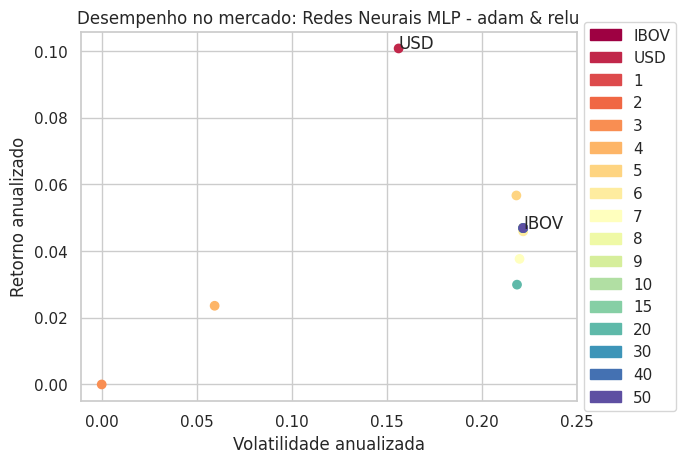

In [ ]:
# Gráfico retorno aa vs. volatilidade aa
def graf_ret_vol(df, solver, f_act):
  cmap = matplotlib.cm.get_cmap('Spectral')
  N = len(df['id'])
  colors = np.linspace(0, 1, N)

  handles = []
  for i,j in zip(df['id'], colors):
    handles.append(mpatches.Patch(color=cmap(j), label=i))
  #print(handles)

  plt.scatter(df['vol_aa'], df['ret_aa'], c=cmap(colors))
  plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

  for i in range(0, 2):
    plt.annotate(df['id'][i], (df['vol_aa'][i], df['ret_aa'][i]))

  plt.xlim(right=0.25)
  plt.xlabel('Volatilidade anualizada')
  plt.ylabel('Retorno anualizado')
  plt.title('Desempenho no mercado: Redes Neurais MLP - ' + f'{solver} & {f_act}')
  plt.show()

graf_ret_vol(df, solver, f_act)

> Em termos do reflexo do comportamento nos números, temos que de fato nenhuma MLP foi capaz de obter um retorno anualizado maior do que o do dólar, no entanto há dois destaques:
* *Rede neural MLP com 5 neurônios intermediários* foi capaz de superar o retorno do IBOV, com uma volatilidade levemente menor do que IBOV;
* *Rede neural MLP com 4 neurônios intermediários* obteve um retorno que é metade do obtido para IBOV (e menos ainda do que o dólar), porém a uma volatilidade incrivelmente baixa, quase um quarto do risco do IBOV, o que pode ser uma boa estratégia de alocação de investimento para alguém procurando retornos com baixo risco.

**OBS (digressão)**: Olhando para o gráfico acima de retorno *vs.* risco, é inevitável não comparar suas semelhanças e diferenças com a teoria de portifólio eficiente de Markowitz. Cada ponto no gráfico acima representa o desempenho de um portifólio dinâmico fruto de uma estratégia de alocação sistemática advinda do treino de uma rede neural MLP, atuando em uma alocação dinâmica binária ([100, 0]% ou [0, 100]%) entre duas classes de ativo, USD e IBOV. Nenhuma delas se saiu melhor do que as classes de ativos individualmente, em termos da combinação retorno-risco; conclusão a qual podemos chegar tendo como base a teoria de Markowitz de quais seriam os valores possíveis (e os melhores) de se obter ao se combinar em um portifólio proporções de USD e IBOV ao mesmo tempo. Pela teoria de Markowitz, seriam possíveis a formação de portifólios que performassem à esquerda de ambos, USD e IBOV, com retorno entre eles, com o ideal sendo os pontos na fronteira eficiente: maior retorno esperado para o menor risco associado.

Nosso portifólio é 100% IBOV ou USD em um dado instante de tempo e dinâmico no decorrer do tempo, o que é algo diferente do escopo de Markowitz, contudo o que se esperava do uso de ferramentas de inteligência artificial e *machine learning* é que as MLPs pudessem ser capazes de encontrar padrões que nós não conseguimos, definindo uma tomada de decisões resultando em uma melhor performance do que até mesmo é previsto por Markowitz. Entretanto, para os parêmtros e conjuntos de dados providos para a rede, esse não foi o caso e ainda sim é curioso que nenhuma das MLPs caiu em pontos onde estaria desenhada a fronteira eficiente de Markowitz considerando USD e IBOV como ativos.

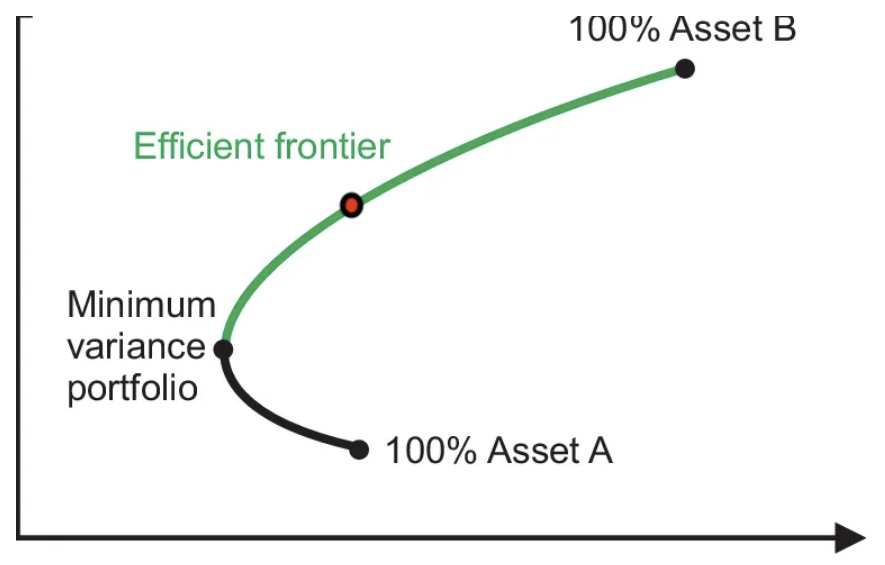

## Rede Neural MLP: lbfgs & tanh
Solver: 'lbfgs' e activation: 'tanh'

Na busca por melhores resultados com MLPs, os parâmetros do modelo foram explorados, dessa vez com alteração do *solver* e da função de ativação, nesse caso empregando 'lbfgs' e tangente hiperbólica para computo da rede.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

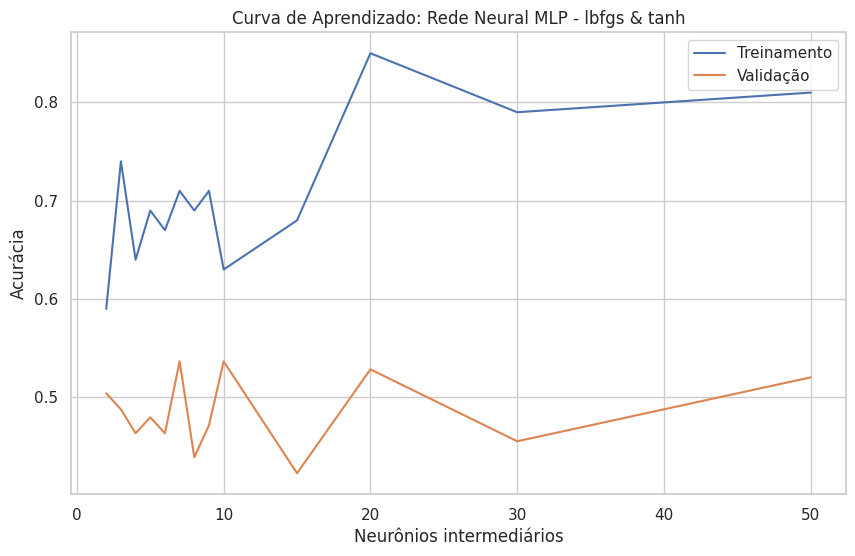

In [ ]:
# Treinamento com Redes Neurais MLP (MultiLayer Perceptron)
#solver: 'lbfgs', função de ativação: 'tanh'
#Diferentes quantidades de neurônios intermediários

solver = 'lbfgs'
f_act = 'tanh'
hidden1 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]
max_iter = 1e3 #10**18
acc_train = []
acc_val = []

for h1 in hidden1:
  y_pred = mlp(solver, f_act, h1, max_iter, train_in, train_out, val_in, val_out)

# Curva de aprendizado: acurácia vs. neurônios intermediários
plt.figure(figsize = (10, 6))
plt.plot(hidden1, acc_train)
plt.plot(hidden1, acc_val)
plt.legend(['Treinamento', 'Validação'])
plt.title('Curva de Aprendizado: Rede Neural MLP - lbfgs & tanh')
plt.xlabel('Neurônios intermediários')
plt.ylabel("Acurácia")
plt.show()

> OBS: 10 elevado a 18 interações, para nº de neurônios intermediários igual a 5 já retornava o seguinte aviso:

> ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In [ ]:
print('Accuracy training:', acc_train)
print('Accuracy validation:', acc_val)

Accuracy training: [0.59, 0.74, 0.64, 0.69, 0.67, 0.71, 0.69, 0.71, 0.63, 0.68, 0.85, 0.79, 0.8, 0.81]
Accuracy validation: [0.5040650406504065, 0.4878048780487805, 0.4634146341463415, 0.4796747967479675, 0.4634146341463415, 0.5365853658536586, 0.43902439024390244, 0.4715447154471545, 0.5365853658536586, 0.42276422764227645, 0.5284552845528455, 0.45528455284552843, 0.4878048780487805, 0.5203252032520326]


> Embora supostamente o *solver* 'lbfgs' seja bom para datasets pequenos, que é o nosso caso, sua combinação com a função de ativação 'tanh' não convergiu nos testes performados. Não se pode concluir muita coisa do desempenho dessas MLPs, no entanto, uma olhada para os valores finais devolvidos pelo algoritmo mesmo sem convergir mostram acurácia não tão altas para o treinamento e baixas para o conjunto de validação.

## Rede Neural MLP: sgd & relu
Solver: 'sgd' e activation: 'relu'

Numa última tentativa de se obter bons resultados de alocação sistemática usando o poder das redes MLPs, testou-se a construção de MLPs com *solver* sgd e função de ativação 'relu'.

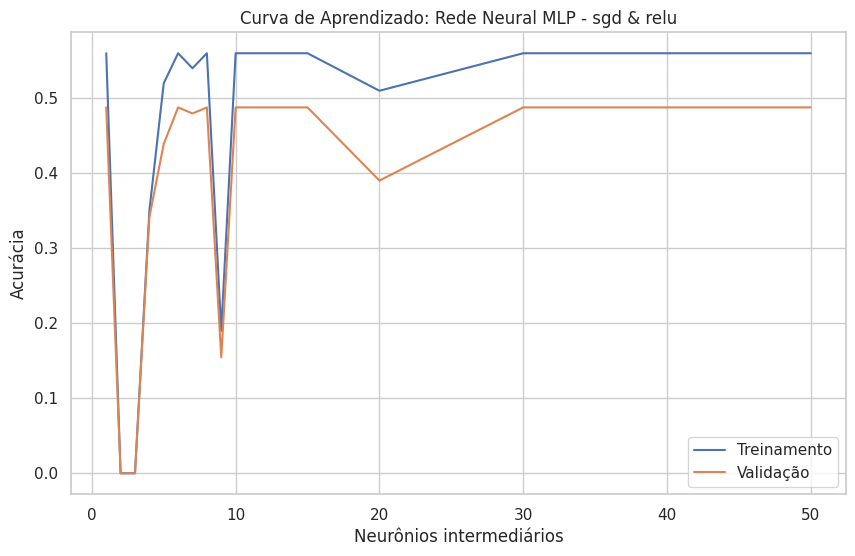

In [ ]:
# Treinamento com Redes Neurais MLP (MultiLayer Perceptron)
#solver: 'lbfgs', função de ativação: 'tanh'
#Diferentes quantidades de neurônios intermediários

solver = 'sgd'
f_act = 'relu'
hidden1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]
max_iter = 1e10 #10**18
acc_train = []
acc_val = []

for h1 in hidden1:
  y_pred = mlp(solver, f_act, h1, max_iter, train_in, train_out, val_in, val_out)

# Curva de aprendizado: acurácia vs. neurônios intermediários
plt.figure(figsize = (10, 6))
plt.plot(hidden1, acc_train)
plt.plot(hidden1, acc_val)
plt.legend(['Treinamento', 'Validação'])
plt.title('Curva de Aprendizado: Rede Neural MLP - sgd & relu')
plt.xlabel('Neurônios intermediários')
plt.ylabel("Acurácia")
plt.show()

> Da curva de aprendizado dos modelos, observa-se um processo não-linear, com  saturação da acurácia para uma camada intermediária com muitos neurônios em torno de 55% para o treinamento e um pouco abaixo dos 50% para o conjunto de validação. Para essa escolha do parâmetro *solver* e *activation*, parece ter havido uma maior oscilação no processo de aprendizado, refletido pelas suidas e descidas da acurácia do modelo em ambas as etapas.

In [ ]:
# Retorno & Volatilidade
acc_train = []
acc_val = []
hidden1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]

dados_apr = df_dados_apr(dados_chg, dados_mom1, dados_mom3, dados_mom6)

for i in hidden1:
  y_pred = mlp(solver, f_act, i, max_iter, train_in, train_out, val_in, val_out)

  # Copiando saídas do algoritmo de aprendizado para o data frame
  dados_apr['IBOV-BUY-APR' + str(i)] = np.argmin(y_pred, axis=1)
  dados_apr['USD-BUY-APR' + str(i)] = np.argmax(y_pred, axis=1)

  #deslocando um mês para frente, pois tem que estimar o mês seguinte (futuro)
  dados_apr['IBOV-BUY-APR' + str(i)] = dados_apr['IBOV-BUY-APR' + str(i)].shift(1)
  dados_apr['USD-BUY-APR' + str(i)] = dados_apr['USD-BUY-APR' + str(i)].shift(1)

  #Calculando o resultado acumulado do investimento utilizando aprendizado
  dados_apr['APR-CHG' + str(i)] = dados_apr['IBOV'] * dados_apr['IBOV-BUY-APR' + str(i)] + dados_apr['USD'] * dados_apr['USD-BUY-APR' + str(i)]
  dados['APR-ACC' + str(i)] = (1 + dados_apr['APR-CHG' + str(i)]).cumprod()

ret_acc, ret_aa, vol_aa = ret_vol(n_train, dados, dados_apr)

hidden1 = ['IBOV', 'USD', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]
df = create_df(hidden1, ret_acc, ret_aa, vol_aa)

print(df)

      id   ret_acc    ret_aa    vol_aa
0   IBOV  1.655753  0.046908  0.221852
1    USD  2.875453  0.100780  0.156292
2      1  1.655753  0.046908  0.221852
3      2  1.000000  0.000000  0.000000
4      3  1.000000  0.000000  0.000000
5      4  1.230694  0.019050  0.186776
6      5  1.911149  0.060650  0.211936
7      6  1.655753  0.046908  0.221852
8      7  1.501787  0.037661  0.219949
9      8  1.655753  0.046908  0.221852
10     9  0.760986 -0.024525  0.145640
11    10  1.655753  0.046908  0.221852
12    15  1.655753  0.046908  0.221852
13    20  0.798425 -0.020257  0.209398
14    30  1.655753  0.046908  0.221852
15    40  1.655753  0.046908  0.221852
16    50  1.655753  0.046908  0.221852


<ipython-input-109-3fae21455b58>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


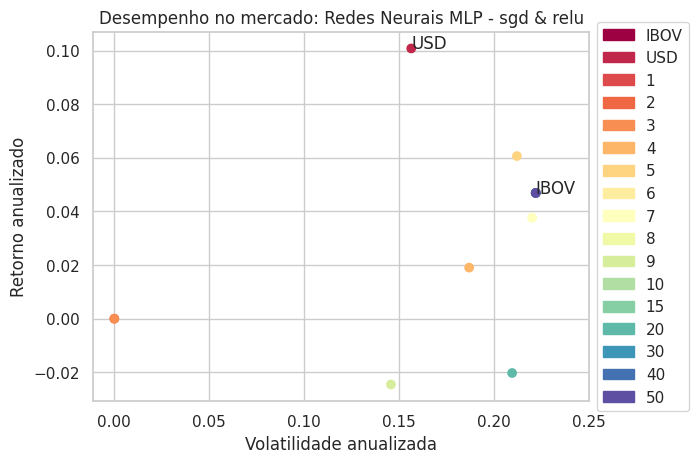

In [ ]:
graf_ret_vol(df, solver, f_act)

> As baixas acurácias dos modelos MLPs construídos, se refletiram em nenhum deles apresentando retornos maiores do que USD e IBOV, com inclusive algumas estratégias levando a uma perda de capital ao final do período com retorno anualizado negativo (para 9 e 20 neurônios intermediários).

# Resumo dos resultados

**Árvores de decisão**
* Indicação de que o momento do último 1 mês é muito relevante para a alocação sistemática entre as classes de ativos dólar americano (USD) e Ibovespa (IBOV);
* Maior acurácia no conjunto de validação (50,4%) obtido para profundidade máxima da árvore de 4 nós;
* Obtenção de uma estratégia de alocação em classes USD/IBOV com retorno superior as classes individualmente e volatilidade entre elas.

**Redes Neurais Artificiais: Multilayer Perceptron**
* No geral, os resultados retorno-risco dos modelos MLPs construídos foram ruins: retornos abaixo de USD e IBOV para altas volatilidades;
* Obtenção de uma estratégia de alocação em classes (MPL, solver: 'adam', activation: 'relu', 4 neurônios intermediários) com metade do retorno do IBOV, porém com 1/4 da volatilidade.

De modo geral, vimos que a curva de aprendizado dos modelos é não-linear e que o ajuste de um único parâmetro não é capaz de resolver todos os problemas de se encontrar padrões em dados comolexos. Algumas possibilidades na direção de se melhorar os resultados obtidos, seria o uso de um maior conjunto de dados de entrada (236 entradas parece pouco no mundo do aprendizado de máquina), a divisão em mais partições de treinamento e validação e o ajuste e exploração de outros parâmtros de ambos os modelos, buscando otimização.  

# Conclusão

A inteligência artificial e ferramentas de *machine learning* são novidades que chegaram para auxiliar (e revolucionar) os processos de tomada de decisão. Nada mais natural do que tentar aplicá-la nos mais diversos campos de atuação, em especial no mercado financeiro, onde há grande interesse econômico por trás e uma grande quantidade de dados quantitativos para serem trabalhados e manipulados. No trabalho 3, foi possível construiur e ter um primeiro contato com os algoritmos de Árvore de Decisão e Redes Neurais Artificiais por meio dos Multilayer Perceptrons, e explorar como seus parâmetros são capazes de alterar os resultados dos modelos. De modo geral, vimos que é possível empregar algoritmos de *machine learning* no contexto de finanças, no entanto, ainda há um longo caminho a ser percorrido para aperfeiçoar os modelos e obter estratégias de alocação em classes de ativos consistentes de boa acurácia que reflitam em boas performances em termos de retorno e risco.  